In [8]:
# Import core libraries used in production data pipelines
import pandas as pd
import numpy as np

# Improve DataFrame visualization (useful for debugging in Colab)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.2f}".format)

# Check Pandas version (important for production reproducibility)
print("Pandas version:", pd.__version__)


Pandas version: 2.2.2


In [9]:
def generate_transactions(
    n_rows: int = 100_000,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Generate synthetic transactional data.

    Parameters:
    - n_rows: number of records to generate
    - random_state: ensures reproducibility

    Returns:
    - Pandas DataFrame with transaction data
    """

    # Set random seed for reproducibility in production
    np.random.seed(random_state)

    # Create synthetic dataset
    data = {
        # Unique transaction identifier
        "transaction_id": np.arange(1, n_rows + 1),

        # Simulated customer IDs
        "customer_id": np.random.randint(1, 5000, n_rows),

        # Transaction amount using exponential distribution
        # (common for real-world financial data)
        "amount": np.random.exponential(scale=120, size=n_rows),

        # Business categories
        "category": np.random.choice(
            ["Food", "Electronics", "Clothing", "Health"],
            size=n_rows
        ),

        # Random transaction dates within one year
        "transaction_date": (
            pd.to_datetime("2024-01-01") +
            pd.to_timedelta(np.random.randint(0, 365, n_rows), unit="D")
        )
    }

    # Return data as Pandas DataFrame
    return pd.DataFrame(data)


# Generate dataset
df = generate_transactions()

# Preview data
df.head()


,transaction_id,customer_id,amount,category,transaction_date
0,1,861,130.68,Clothing,2024-07-09
1,2,3773,93.35,Clothing,2024-12-15
2,3,3093,75.65,Food,2024-10-30
3,4,467,71.10,Health,2024-05-03
4,5,4427,18.38,Clothing,2024-03-09


In [10]:
def validate_data(df: pd.DataFrame) -> None:
    """
    Validate data quality rules.
    Raises errors if any rule fails.
    """

    # Ensure there are no missing values
    assert df.isnull().sum().sum() == 0, "❌ Null values detected"

    # Ensure no negative transaction amounts
    assert (df["amount"] >= 0).all(), "❌ Negative amounts found"

    # Ensure transaction IDs are unique
    assert df["transaction_id"].is_unique, "❌ Duplicate transaction IDs detected"


# Run validation checks
validate_data(df)
print("✅ Data validation passed")


✅ Data validation passed


In [11]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and standardize data.
    """

    # Create a copy to avoid mutating original data
    df = df.copy()

    # Round monetary values to 2 decimals (financial standard)
    df["amount"] = df["amount"].round(2)

    # Normalize category names for consistency
    df["category"] = df["category"].str.lower()

    return df


# Apply cleaning
df = clean_data(df)

df.head()


,transaction_id,customer_id,amount,category,transaction_date
0,1,861,130.68,clothing,2024-07-09
1,2,3773,93.35,clothing,2024-12-15
2,3,3093,75.65,food,2024-10-30
3,4,467,71.10,health,2024-05-03
4,5,4427,18.38,clothing,2024-03-09


In [12]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create new features used for analytics and reporting.
    """

    df = df.copy()

    # Extract month from transaction date
    df["month"] = df["transaction_date"].dt.month

    # Extract year from transaction date
    df["year"] = df["transaction_date"].dt.year

    # Flag high-value transactions
    df["high_value_tx"] = df["amount"] > 300

    return df


# Apply feature engineering
df = feature_engineering(df)

df.head()


,transaction_id,customer_id,amount,category,transaction_date,month,year,high_value_tx
0,1,861,130.68,clothing,2024-07-09,7,2024,False
1,2,3773,93.35,clothing,2024-12-15,12,2024,False
2,3,3093,75.65,food,2024-10-30,10,2024,False
3,4,467,71.10,health,2024-05-03,5,2024,False
4,5,4427,18.38,clothing,2024-03-09,3,2024,False


In [13]:
# Aggregate data by time and category
monthly_sales = (
    df
    .groupby(["year", "month", "category"])
    .agg(
        # Total revenue per group
        total_sales=("amount", "sum"),

        # Average transaction value
        avg_ticket=("amount", "mean"),

        # Number of transactions
        transactions=("transaction_id", "count")
    )
    .reset_index()
)

# Preview aggregated results
monthly_sales.head()


,year,month,category,total_sales,avg_ticket,transactions
0,2024,1,clothing,266059.24,122.16,2178
1,2024,1,electronics,253932.87,121.50,2090
2,2024,1,food,260596.74,122.12,2134
3,2024,1,health,271696.55,123.44,2201
4,2024,2,clothing,232068.44,118.22,1963


In [14]:
# Calculate core KPIs
kpis = {
    # Total revenue across all transactions
    "total_revenue": df["amount"].sum(),

    # Average transaction size
    "average_transaction": df["amount"].mean(),

    # Percentage of high-value transactions
    "high_value_ratio": df["high_value_tx"].mean()
}

# Convert KPIs to DataFrame for reporting
pd.DataFrame.from_dict(kpis, orient="index", columns=["value"])


,value
total_revenue,12017590.85
average_transaction,120.18
high_value_ratio,0.08


In [15]:
# Export aggregated data in efficient format
monthly_sales.to_parquet("monthly_sales.parquet", index=False)

# Export a sample dataset for audits or analysis
df.sample(5000).to_csv("sample_transactions.csv", index=False)

print("📦 Production files exported successfully")


📦 Production files exported successfully


In [16]:
def run_pipeline() -> pd.DataFrame:
    """
    Full production pipeline:
    data generation -> validation -> cleaning -> feature engineering -> aggregation
    """

    # Step 1: Load / generate data
    df = generate_transactions()

    # Step 2: Validate raw data
    validate_data(df)

    # Step 3: Clean data
    df = clean_data(df)

    # Step 4: Feature engineering
    df = feature_engineering(df)

    # Step 5: Final business aggregation
    summary = (
        df
        .groupby("category")
        .agg(total_sales=("amount", "sum"))
        .reset_index()
    )

    return summary


# Run production pipeline
pipeline_output = run_pipeline()
pipeline_output


,category,total_sales
0,clothing,2987085.23
1,electronics,2977519.45
2,food,3027082.48
3,health,3025903.69


In [17]:
# Matplotlib is widely used in production analytics
import matplotlib.pyplot as plt


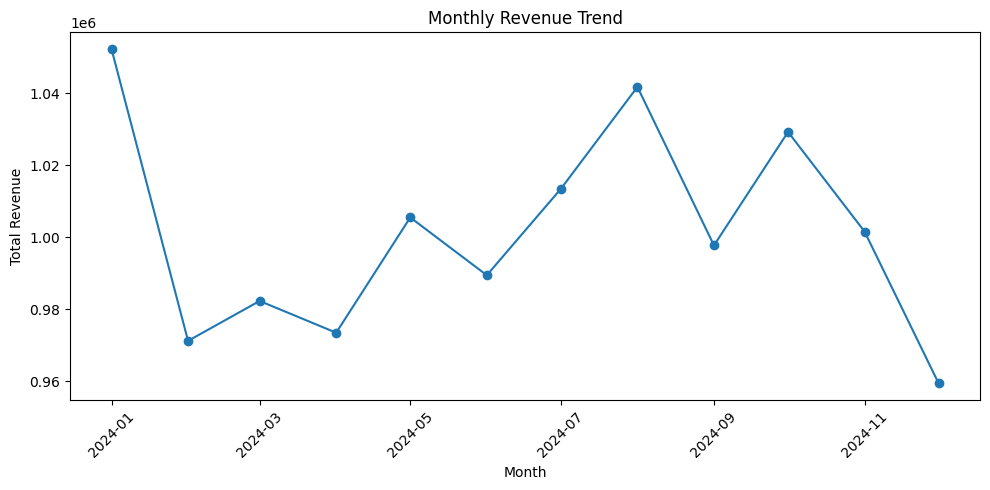

In [19]:
# Aggregate revenue by month
monthly_revenue = (
    df
    .groupby(["year", "month"])["amount"]
    .sum()
    .reset_index()
)

# Create a datetime column for plotting
monthly_revenue["date"] = pd.to_datetime(
    monthly_revenue["year"].astype(str) + "-" +
    monthly_revenue["month"].astype(str) + "-01"
)

# Plot time series
plt.figure(figsize=(10, 5))
plt.plot(monthly_revenue["date"], monthly_revenue["amount"], marker="o")

# Titles and labels
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue")

# Rotate dates for readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


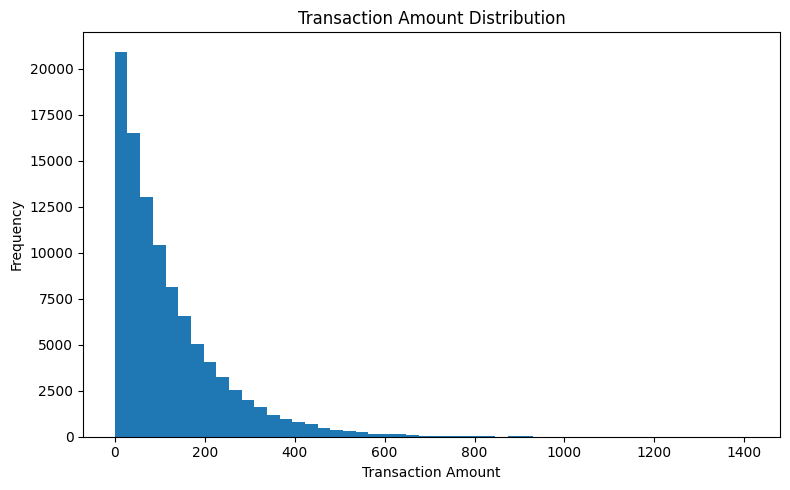

In [20]:
# Plot distribution of transaction amounts
plt.figure(figsize=(8, 5))
plt.hist(df["amount"], bins=50)

# Titles and labels
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


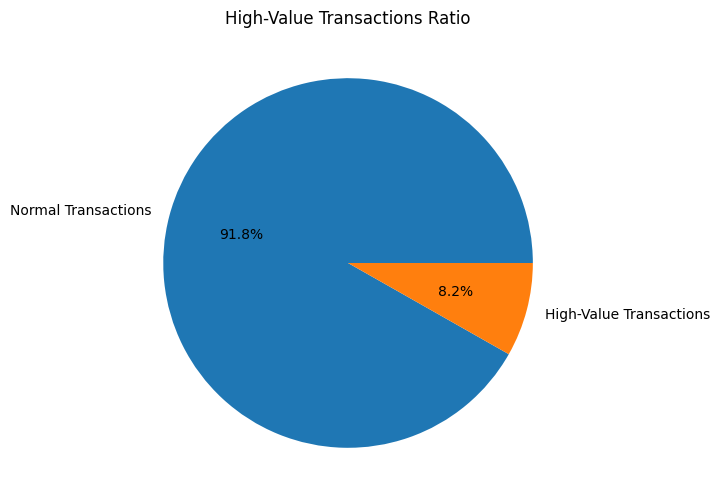

In [21]:
# Calculate percentage of high-value transactions
high_value_ratio = (
    df["high_value_tx"]
    .value_counts(normalize=True)
    * 100
)

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    high_value_ratio,
    labels=["Normal Transactions", "High-Value Transactions"],
    autopct="%.1f%%"
)

plt.title("High-Value Transactions Ratio")
plt.show()
